In [1]:
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ubw8t3fp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Analyze Slide-seqV2 data
========================

This tutorial shows how to apply Squidpy for the analysis of Slide-seqV2
data.

The data used here was obtained from `Stickels2020-rf`. We provide a
pre-processed subset of the data, in `anndata.AnnData` format. We would
like to thank \@tudaga for providing cell-type level annotation. For
details on how it was pre-processed, please refer to the original paper.

::: {.seealso}
See `sphx_glr_auto_tutorials_tutorial_visium_hne.py` and
`sphx_glr_auto_tutorials_tutorial_seqfish.py` for additional analysis
examples.
:::

Import packages & data
----------------------

To run the notebook locally, create a conda environment as *conda env
create -f environment.yml* using this
[environment.yml](https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml).


In [2]:
import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
adata = sq.datasets.slideseqv2()
adata

scanpy==1.9.1 anndata==0.7.8 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.2.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
squidpy==1.2.2


  0%|          | 0.00/251M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

First, let\'s visualize cluster annotation in spatial context with
`scanpy.pl.spatial`.


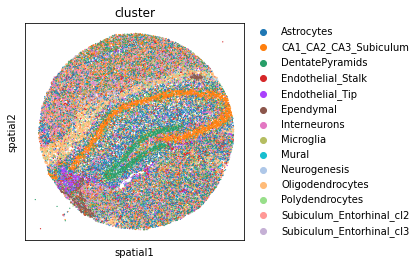

In [3]:
sc.pl.spatial(adata, color="cluster", spot_size=30)

Neighborhood enrichment analysis
================================

Similar to other spatial data, we can investigate spatial organization
of clusters in a quantitative way, by computing a neighborhood
enrichment score. You can compute such score with the following
function: `squidpy.gr.nhood_enrichment`. In short, it\'s an enrichment
score on spatial proximity of clusters: if spots belonging to two
different clusters are often close to each other, then they will have a
high score and can be defined as being *enriched*. On the other hand, if
they are far apart, the score will be low and they can be defined as
*depleted*. This score is based on a permutation-based test, and you can
set the number of permutations with the [n\_perms]{.title-ref} argument
(default is 1000).

Since the function works on a connectivity matrix, we need to compute
that as well. This can be done with `squidpy.gr.spatial_neighbors`.
Please see `sphx_glr_auto_examples_graph_compute_spatial_neighbors.py`
and `sphx_glr_auto_examples_graph_compute_nhood_enrichment.py` for more
details of how these functions works.

Finally, we\'ll directly visualize the results with
`squidpy.pl.nhood_enrichment`. We\'ll add a dendrogram to the heatmap
computed with linkage method *ward*.


  0%|          | 0/1000 [00:00<?, ?/s]

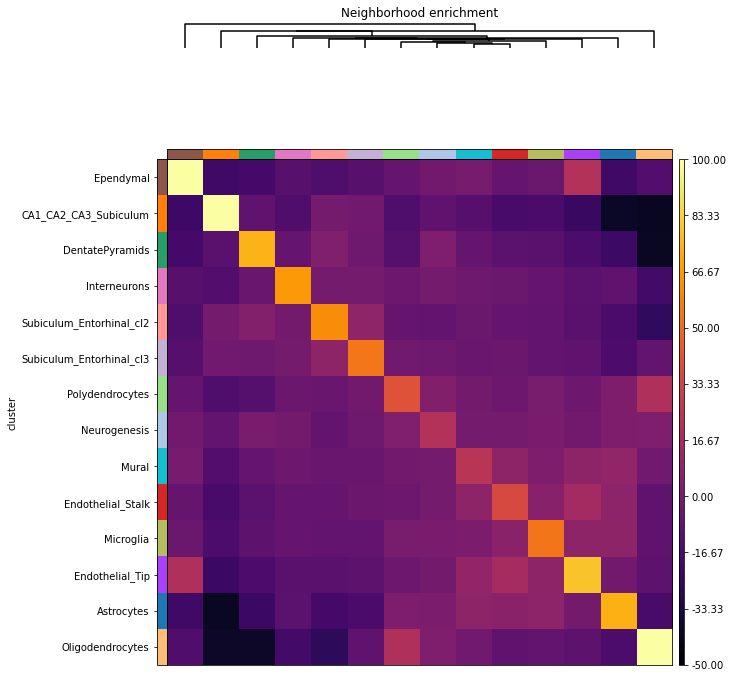

In [4]:
sq.gr.spatial_neighbors(adata, coord_type="generic")
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster", method="single", cmap="inferno", vmin=-50, vmax=100)

Interestingly, there seems to be an enrichment between the
*Endothelial\_Tip*, the *Ependymal* cells. Another putative enrichment
is between the *Oligodendrocytes* and *Polydendrocytes* cells. We can
visualize the spatial organization of such clusters. For this, we\'ll
use `scanpy.pl.spatial` again.


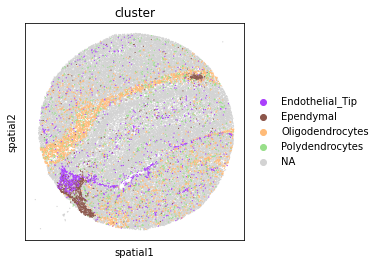

In [5]:
sc.pl.spatial(
    adata,
    color="cluster",
    groups=["Endothelial_Tip", "Ependymal", "Oligodendrocytes", "Polydendrocytes"],
    spot_size=30,
)

Ripley\'s statistics
====================

In addition to the neighbor enrichment score, we can further investigate
spatial organization of cell types in tissue by means of the Ripley\'s
statistics. Ripley\'s statistics allow analyst to evaluate whether a
discrete annotation (e.g. cell-type) appears to be clustered, dispersed
or randomly distributed on the area of interest. In Squidpy, we
implement three closely related Ripley\'s statistics, that can be easily
computed with `squidpy.gr.ripley`. Here, we\'ll showcase the Ripley\'s L
statistic, which is a variance-stabilized version of the Ripley\'s K
statistics. We\'ll visualize the results with `squidpy.pl.ripley`. Check
`sphx_glr_auto_examples_graph_compute_ripley.py` for more details.


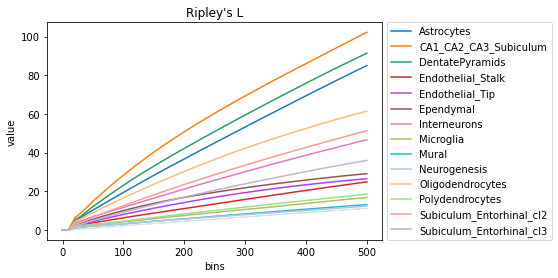

In [6]:
mode = "L"
sq.gr.ripley(adata, cluster_key="cluster", mode=mode, max_dist=500)
sq.pl.ripley(adata, cluster_key="cluster", mode=mode)

The plot highlight how some cell-types have a more clustered pattern,
like *Astrocytes* and *CA11\_CA2\_CA3\_Subiculum* cells, whereas other
have a more dispersed pattern, like *Mural* cells. To confirm such
interpretation, we can selectively visualize again their spatial
organization.


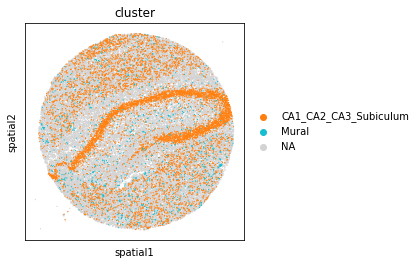

In [7]:
sc.pl.spatial(
    adata,
    color="cluster",
    groups=["Mural", "CA1_CA2_CA3_Subiculum"],
    spot_size=30,
)

Ligand-receptor interaction analysis
====================================

The analysis showed above has provided us with quantitative information
on cellular organization and communication at the tissue level. We might
be interested in getting a list of potential candidates that might be
driving such cellular communication. This naturally translates in doing
a ligand-receptor interaction analysis. In Squidpy, we provide a fast
re-implementation the popular method CellPhoneDB `cellphonedb`
([code](https://github.com/Teichlab/cellphonedb) ) and extended its
database of annotated ligand-receptor interaction pairs with the popular
database *Omnipath* `omnipath`. You can run the analysis for all
clusters pairs, and all genes (in seconds, without leaving this
notebook), with `squidpy.gr.ligrec`.

Let\'s perform the analysis and visualize the result for three clusters
of interest: *Polydendrocytes* and *Oligodendrocytes*. For the
visualization, we will filter out annotations with low-expressed genes
(with the `means_range` argument) and decreasing the threshold for the
adjusted p-value (with the `alpha` argument) Check
`sphx_glr_auto_examples_graph_compute_ligrec.py` for more details.


/opt/conda/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = data["clusters"].cat.remove_unused_categories()
/opt/conda/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = cat.rename_categories(cluster_mapper)


  0%|          | 0/100 [00:00<?, ?permutation/s]

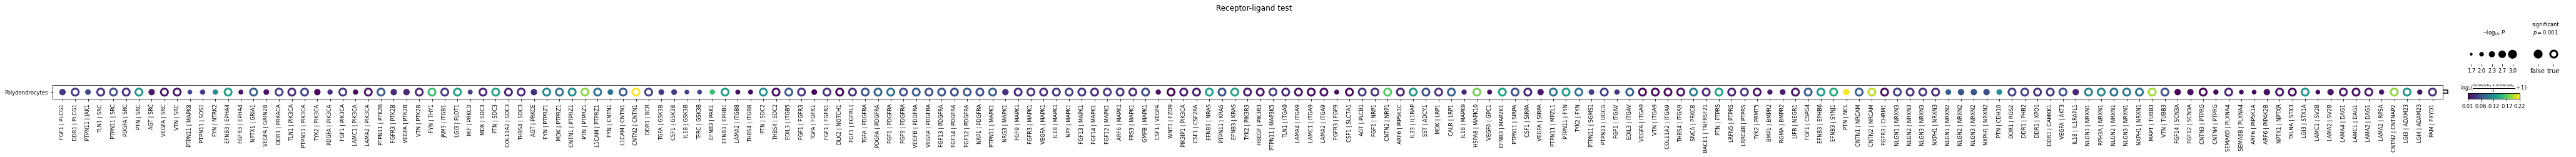

In [8]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="cluster",
    clusters=["Polydendrocytes", "Oligodendrocytes"],
)
sq.pl.ligrec(
    adata,
    cluster_key="cluster",
    source_groups="Oligodendrocytes",
    target_groups=["Polydendrocytes"],
    pvalue_threshold=0.05,
    swap_axes=True,
)

The dotplot visualization provides an interesting set of candidate
interactions that could be involved in the tissue organization of the
cell types of interest. It should be noted that this method is a pure
re-implementation of the original permutation-based test, and therefore
retains all its caveats and should be interpreted accordingly.


Spatially variable genes with spatial autocorrelation statistics
================================================================

Lastly, with Squidpy we can investigate spatial variability of gene
expression. `squidpy.gr.spatial_autocorr` conveniently wraps two spatial
autocorrelation statistics: *Moran\'s I* and *Geary\'s C. They provide a
score on the degree of spatial variability of gene expression. The
statistic as well as the p-value are computed for each gene, and FDR
correction is performed. For the purpose of this tutorial, let\'s
compute the*Moran\'s I\* score. See
`sphx_glr_auto_examples_graph_compute_moran.py` for more details.


In [9]:
sq.gr.spatial_autocorr(adata, mode="moran")
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_norm_fdr_bh
Ttr,0.703289,0.0,0.000008,0.0
Plp1,0.531680,0.0,0.000008,0.0
Mbp,0.495970,0.0,0.000008,0.0
Hpca,0.490302,0.0,0.000008,0.0
Enpp2,0.455090,0.0,0.000008,0.0
1500015O10Rik,0.453225,0.0,0.000008,0.0
Pcp4,0.428500,0.0,0.000008,0.0
Sst,0.398053,0.0,0.000008,0.0
Ptgds,0.385718,0.0,0.000008,0.0
Nrgn,0.368533,0.0,0.000008,0.0


The results are stored in [adata.uns\[\"moranI\"\]]{.title-ref} and we
can visualize selected genes with `scanpy.pl.spatial`.


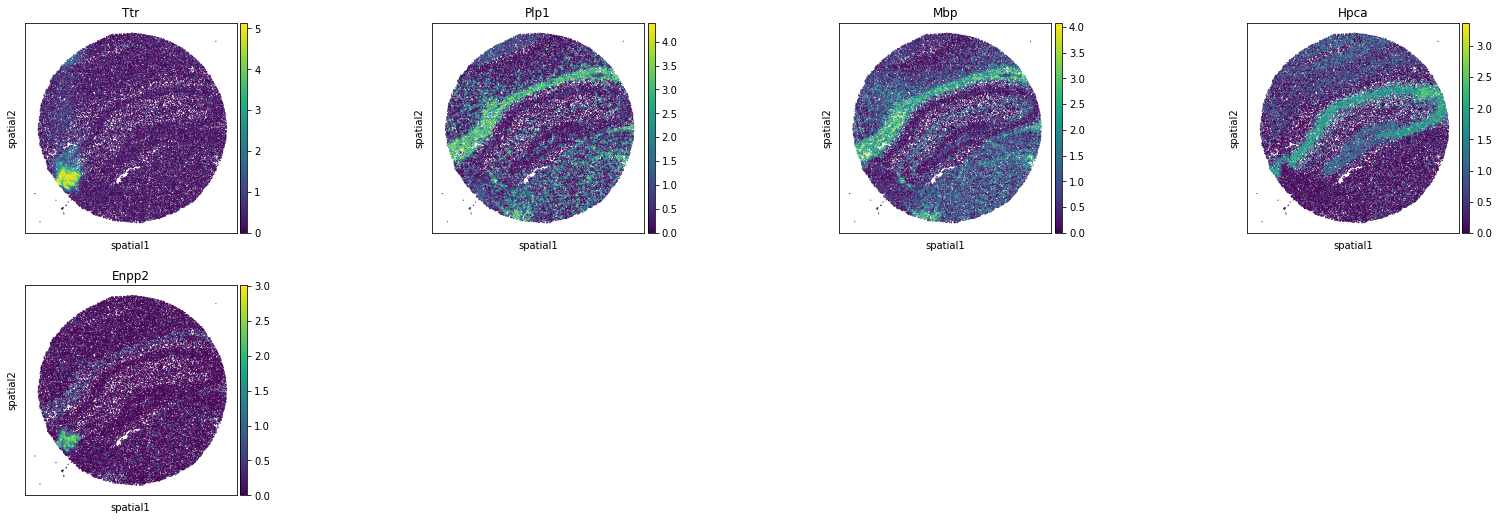

In [10]:
sc.pl.spatial(
    adata,
    color=["Ttr", "Plp1", "Mbp", "Hpca", "Enpp2"],
    spot_size=30,
)